# Functional Encryption - Classification and information leakage
 
We give here a thorough analysis of the impact of the output size on the main and collateral accuracies.

For this part we have trained many models on a server, for each output size and with 7-fold cross validation. The training is not very different than before, except that it is very long. So we just provide the results here.

# 11. Influence of the output size


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

from os import listdir
from os.path import isfile, join, isdir

In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pylab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 50
        self.new_adversary_epochs = 50
        self.lr = 0.001
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 10000

In [4]:
N_CHARS = 10
N_FONTS = 2

## 11.1 Net structure

In [5]:
class CollateralNet(nn.Module):
    def __init__(self, private_output_size):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, private_output_size, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(private_output_size, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(private_output_size, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
        # FFN for families
        self.lin3 = nn.Linear(private_output_size, 64)
        self.lin4 = nn.Linear(64, 32)
        self.lin5 = nn.Linear(32, 16)
        self.lin6 = nn.Linear(16, 8)
        self.lin7 = nn.Linear(8, N_CHARS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

Loop on models loaded

## 8.2 Testing distinguishability against multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

We now perform only the last phase with the new adversary, note that we change the data loader

In [6]:
fonts = ['cursive', 'Georgia']
letter = "6"

def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.data.get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [7]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [8]:
resistance_reports = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [9]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model, output_size):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = output_size
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

In [10]:
path = 'models'
files = sorted(
    [join(path, f) for f in listdir(path) if isfile(join(path, f)) and 'par2' in f], 
    key=lambda x: int(x.split('_')[4])
)

print('\n'.join(files))

models = []
output_sizes = []
for file in files:
    output_size = int(file.split('_')[4])
    model = CollateralNet(output_size)
    model.load_state_dict(torch.load(file))
    model.eval()                                                                                                                                                    
    models.append(model)
    output_sizes.append(output_size)
    
print("Evaluation on output_sizes:", output_sizes)

architecture = [64, 32, 16, 8]

results = {}
def show_collateral_acc_w_output_size(architecture):
    for output_size, model in zip(output_sizes, models):
        quadratic_model = model
        quadratic_model.freeze('quad')
        model = FFNet(architecture, quadratic_model, output_size)
        model.freeze('quad')
        print(f"*{output_size}")
        _, test_perfs_font = evaluate_resistance(model)
        print(test_perfs_font)
        
        key = f"Collateral with output size {output_size}"
        if key not in results:
            results[key] = []
        results[key].append(test_perfs_font)
        
    x = []
    y_coll = []
    for task, res in results.items():
        x.append(float(task.split(' ')[-1]))
        y_coll.append(np.mean(res[-10:]))
        
    print(y_coll)

    plt.figure(figsize=(10, 4))
    plt.plot(x, y_coll, label="Collateral task")
    plt.ylabel('Accuracy in %')
    plt.xlabel('Private output size')
    #plt.ylim(,)
    plt.title("")
    plt.legend()
    plt.show()
    return results


models/quadconvnet_0.5_0.002_1.7_1_2_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_3_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_1_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_0_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_5_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_4_par2.pt
models/quadconvnet_0.5_0.002_1.7_1_6_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_6_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_5_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_4_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_1_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_0_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_2_par2.pt
models/quadconvnet_0.5_0.002_1.7_2_3_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_5_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_4_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_6_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_2_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_3_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_1_par2.pt
models/quadconvnet_0.5_0.002_1.7_3_0_par2.pt
models/quadconvnet_0.5_0.002_1.7_4_6_par2.pt
models/qua

I told you there were a lot of them

In [99]:
def draw_paretto(collateral_results, main_results):
    """
    Make the output size vary
    each key of the dict corresponds to one output size
    and contains a list of results (based on different cross validations)
    """
    output_sizes = []
    x_coll = []
    for key, result_list in collateral_results.items():
        output_size = int(key.split(' ')[-1])
        output_sizes.append(output_size)
        x_coll.append([np.mean(result[-10:]) for result in result_list])
        

    plt.figure(figsize=(8, 4))
    sizes = [str(e) for e in output_sizes]

    data = x_coll

    plt.boxplot(data, showfliers=False)

    #plt.ylim(0,30)

    pylab.xticks(range(1, len(sizes) + 1), sizes)
    
    plt.ylabel('Accuracy of the collateral task')
    plt.xlabel('Output size of the private network')
    plt.title("")

    plt.savefig('CollateralAcc_OutputSize.png', dpi=300)
    plt.show()
        
    
        
        

In [54]:
plt.rcParams.update({'font.size': 16})

*1
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.713958

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4748/10000 (47.48%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697134

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4988/10000 (49.88%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694900

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4628/10000 (46.28%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693509

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696835

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4836/10000 (48.36%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691935

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692789

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5061/10000 (50.61%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692995

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5061/10000 (50.61%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691959

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5063/10000 (50.63%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695303

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695797

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5658/10000 (56.58%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694129

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4928/10000 (49.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691652

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5098/10000 (50.98%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693455

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5065/10000 (50.65%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693868

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5060/10000 (50.60%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694608

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697313

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5079/10000 (50.79%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693346

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691150

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5084/10000 (50.84%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693181

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5060/10000 (50.60%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693336

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5063/10000 (50.63%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694191

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696829

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5502/10000 (55.02%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693950

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4917/10000 (49.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689985

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5068/10000 (50.68%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692866

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5066/10000 (50.66%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693155

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5073/10000 (50.73%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694165

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4950/10000 (49.50%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695551

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5625/10000 (56.25%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694053

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4976/10000 (49.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690324

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5067/10000 (50.67%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693171

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5061/10000 (50.61%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691914

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5070/10000 (50.70%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694000

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4950/10000 (49.50%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695742

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5627/10000 (56.27%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694219

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4978/10000 (49.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691392

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5077/10000 (50.77%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693016

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5077/10000 (50.77%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692291

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5084/10000 (50.84%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694505

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4950/10000 (49.50%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695932

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5598/10000 (55.98%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694141

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4985/10000 (49.8

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.725365

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5048/10000 (50.48%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691970

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5055/10000 (50.55%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691643

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5059/10000 (50.59%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692054

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4962/10000 (49.62%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694332

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5844/10000 (58.44%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691049

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6198/10000 (61.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.722246

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5045/10000 (50.45%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689612

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5191/10000 (51.91%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693745

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5155/10000 (51.55%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691122

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5118/10000 (51.18%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702895

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5763/10000 (57.63%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690448

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5764/10000 (57.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.721999

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5046/10000 (50.46%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688478

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5264/10000 (52.64%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690902

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5224/10000 (52.24%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687422

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5394/10000 (53.94%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697350

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5920/10000 (59.20%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687909

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5940/10000 (59.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.721263

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5044/10000 (50.44%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690818

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5135/10000 (51.35%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693737

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5089/10000 (50.89%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692957

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5046/10000 (50.46%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698874

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5856/10000 (58.56%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687435

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5854/10000 (58.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.730773

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5045/10000 (50.45%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691544

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5048/10000 (50.48%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694039

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5049/10000 (50.49%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693823

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5035/10000 (50.35%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698007

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5579/10000 (55.79%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695056

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5750/10000 (57.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.738301

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5048/10000 (50.48%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691164

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5050/10000 (50.50%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693840

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5069/10000 (50.69%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691838

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5033/10000 (50.33%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697841

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5659/10000 (56.59%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696550

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5860/10000 (58.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.720065

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5045/10000 (50.45%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687194

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5373/10000 (53.73%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691235

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5322/10000 (53.22%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683124

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5607/10000 (56.07%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691540

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5915/10000 (59.15%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674744

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5893/10000 (58.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700387

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5067/10000 (50.67%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686177

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5073/10000 (50.73%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689677

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5064/10000 (50.64%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684200

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5095/10000 (50.95%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702901

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5085/10000 (50.85%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693375

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5120/10000 (51.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702931

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4881/10000 (48.81%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690364

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4899/10000 (48.99%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691022

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4925/10000 (49.25%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688108

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4992/10000 (49.92%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697449

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5000/10000 (50.00%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694772

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5100/10000 (51.0

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697703

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4838/10000 (48.38%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692701

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4888/10000 (48.88%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698965

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4930/10000 (49.30%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690528

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5041/10000 (50.41%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695951

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5116/10000 (51.16%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701000

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5174/10000 (51.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698379

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4806/10000 (48.06%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693802

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4887/10000 (48.87%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698377

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4997/10000 (49.97%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694639

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5118/10000 (51.18%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700383

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5117/10000 (51.17%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703876

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5151/10000 (51.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700759

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5151/10000 (51.51%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688765

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5147/10000 (51.47%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689353

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5167/10000 (51.67%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688949

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5187/10000 (51.87%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705544

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5179/10000 (51.79%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699751

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5202/10000 (52.0

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694917

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5316/10000 (53.16%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681919

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5290/10000 (52.90%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679798

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5318/10000 (53.18%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685165

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5322/10000 (53.22%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700862

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5306/10000 (53.06%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691520

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5315/10000 (53.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693072

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5450/10000 (54.50%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677553

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5459/10000 (54.59%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.670054

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5479/10000 (54.79%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684171

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5483/10000 (54.83%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688765

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5489/10000 (54.89%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689991

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5513/10000 (55.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.712857

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5015/10000 (50.15%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693338

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5020/10000 (50.20%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692287

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5047/10000 (50.47%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694014

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4995/10000 (49.95%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694950

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5060/10000 (50.60%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694155

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5211/10000 (52.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.712855

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4918/10000 (49.18%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693400

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5003/10000 (50.03%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692378

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5085/10000 (50.85%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692220

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5136/10000 (51.36%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696174

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5193/10000 (51.93%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693256

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5290/10000 (52.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.716914

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5141/10000 (51.41%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692301

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5132/10000 (51.32%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694472

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5210/10000 (52.10%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692015

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5072/10000 (50.72%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691520

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5246/10000 (52.46%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692739

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5233/10000 (52.3

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.711026

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5077/10000 (50.77%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691951

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5146/10000 (51.46%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694819

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5228/10000 (52.28%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692627

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5168/10000 (51.68%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693090

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5216/10000 (52.16%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693161

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5262/10000 (52.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707789

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4979/10000 (49.79%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694052

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5093/10000 (50.93%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689482

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5201/10000 (52.01%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692986

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5118/10000 (51.18%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694835

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5340/10000 (53.40%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692516

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5381/10000 (53.8

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.715027

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4924/10000 (49.24%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692115

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5007/10000 (50.07%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692164

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5169/10000 (51.69%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692631

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5179/10000 (51.79%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693625

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5190/10000 (51.90%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693555

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5198/10000 (51.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.709276

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4840/10000 (48.40%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692967

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4874/10000 (48.74%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692556

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4908/10000 (49.08%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693152

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5128/10000 (51.28%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694776

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4972/10000 (49.72%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694060

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5106/10000 (51.0

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.767867

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5034/10000 (50.34%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698119

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5225/10000 (52.25%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685837

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5266/10000 (52.66%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688243

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5271/10000 (52.71%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693193

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5301/10000 (53.01%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695443

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5293/10000 (52.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.803970

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5006/10000 (50.06%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698413

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5027/10000 (50.27%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685407

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5035/10000 (50.35%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691669

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5327/10000 (53.27%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698892

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5138/10000 (51.38%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695939

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5279/10000 (52.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.758418

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5096/10000 (50.96%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703917

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5176/10000 (51.76%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692992

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5246/10000 (52.46%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681274

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5372/10000 (53.72%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695167

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5350/10000 (53.50%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699648

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5412/10000 (54.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.781054

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5210/10000 (52.10%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696249

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5343/10000 (53.43%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692844

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5326/10000 (53.26%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688130

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5154/10000 (51.54%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684696

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5300/10000 (53.00%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677596

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5311/10000 (53.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.771020

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5070/10000 (50.70%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695697

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5311/10000 (53.11%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685831

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5381/10000 (53.81%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690454

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5289/10000 (52.89%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698442

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5544/10000 (55.44%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694245

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5457/10000 (54.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.801061

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4921/10000 (49.21%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693962

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5118/10000 (51.18%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691645

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5209/10000 (52.09%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688114

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4977/10000 (49.77%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691754

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5170/10000 (51.70%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683332

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5051/10000 (50.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.770927

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5049/10000 (50.49%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697250

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5058/10000 (50.58%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691867

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5292/10000 (52.92%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691435

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5212/10000 (52.12%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694874

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5370/10000 (53.70%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697307

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5425/10000 (54.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.770192

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5519/10000 (55.19%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683405

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5600/10000 (56.00%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684458

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5603/10000 (56.03%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693551

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5604/10000 (56.04%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686392

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5813/10000 (58.13%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683536

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5991/10000 (59.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.755756

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5155/10000 (51.55%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690290

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5203/10000 (52.03%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693619

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5386/10000 (53.86%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695136

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4944/10000 (49.44%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693919

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5480/10000 (54.80%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693867

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5072/10000 (50.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.804300

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5199/10000 (51.99%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690457

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5330/10000 (53.30%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694564

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5421/10000 (54.21%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695162

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4930/10000 (49.30%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690593

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5561/10000 (55.61%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691938

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5399/10000 (53.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.801937

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5463/10000 (54.63%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688063

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5467/10000 (54.67%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689846

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5490/10000 (54.90%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693447

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5440/10000 (54.40%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686550

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5632/10000 (56.32%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687733

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5745/10000 (57.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.785710

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5303/10000 (53.03%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683083

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5454/10000 (54.54%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690186

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5830/10000 (58.30%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686956

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5503/10000 (55.03%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683602

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6223/10000 (62.23%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672312

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6130/10000 (61.3

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.849429

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5622/10000 (56.22%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689565

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5758/10000 (57.58%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689306

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5874/10000 (58.74%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694040

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5201/10000 (52.01%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687629

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6086/10000 (60.86%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687050

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5715/10000 (57.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.832696

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5520/10000 (55.20%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689430

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5536/10000 (55.36%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691666

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5583/10000 (55.83%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696040

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5256/10000 (52.56%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681099

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5651/10000 (56.51%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681077

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5665/10000 (56.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707746

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5177/10000 (51.77%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678744

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5589/10000 (55.89%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684377

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5739/10000 (57.39%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677462

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5825/10000 (58.25%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.640682

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5990/10000 (59.90%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.631855

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5894/10000 (58.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703936

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5192/10000 (51.92%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678958

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5559/10000 (55.59%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684728

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5840/10000 (58.40%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.655053

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5860/10000 (58.60%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.633455

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5988/10000 (59.88%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.638235

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5985/10000 (59.8

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698044

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5176/10000 (51.76%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690629

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5335/10000 (53.35%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695825

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5429/10000 (54.29%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683230

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5523/10000 (55.23%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676462

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5677/10000 (56.77%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678044

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5774/10000 (57.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706304

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5274/10000 (52.74%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686009

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5332/10000 (53.32%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697228

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5384/10000 (53.84%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679105

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5266/10000 (52.66%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683484

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5522/10000 (55.22%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680035

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5574/10000 (55.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.714309

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5352/10000 (53.52%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687141

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5505/10000 (55.05%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687057

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5518/10000 (55.18%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682445

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5342/10000 (53.42%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678473

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5659/10000 (56.59%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669356

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5746/10000 (57.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.713834

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5418/10000 (54.18%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.659118

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6215/10000 (62.15%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666099

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6157/10000 (61.57%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.628445

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6478/10000 (64.78%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.565321

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6351/10000 (63.51%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.602716

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6269/10000 (62.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693226

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5286/10000 (52.86%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690737

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5217/10000 (52.17%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693414

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5302/10000 (53.02%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690260

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5428/10000 (54.28%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692812

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5402/10000 (54.02%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677996

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5524/10000 (55.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695570

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5552/10000 (55.52%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686415

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5530/10000 (55.30%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693160

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5550/10000 (55.50%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696637

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5422/10000 (54.22%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687922

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5544/10000 (55.44%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686048

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5535/10000 (55.3

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683396

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5753/10000 (57.53%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671679

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6157/10000 (61.57%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.668928

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6654/10000 (66.54%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.615947

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7045/10000 (70.45%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.563372

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6882/10000 (68.82%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.540086

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6225/10000 (62.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689227

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5978/10000 (59.78%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666068

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6916/10000 (69.16%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.618866

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6705/10000 (67.05%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.606412

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7038/10000 (70.38%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.501277

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6537/10000 (65.37%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.585861

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6244/10000 (62.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681579

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5374/10000 (53.74%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683189

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5760/10000 (57.60%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682700

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5798/10000 (57.98%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681340

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5455/10000 (54.55%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.665080

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5699/10000 (56.99%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679402

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5759/10000 (57.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682536

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5534/10000 (55.34%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677792

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5799/10000 (57.99%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693959

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6181/10000 (61.81%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676563

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5855/10000 (58.55%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.661320

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6222/10000 (62.22%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672594

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6206/10000 (62.0

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691443

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5684/10000 (56.84%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687756

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5752/10000 (57.52%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693914

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5862/10000 (58.62%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689848

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5012/10000 (50.12%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685515

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5926/10000 (59.26%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682472

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5819/10000 (58.1

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696039

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5270/10000 (52.70%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687246

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5296/10000 (52.96%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691730

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5300/10000 (53.00%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696500

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5266/10000 (52.66%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689475

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5369/10000 (53.69%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686039

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5347/10000 (53.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.916762

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694597

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4951/10000 (49.51%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692682

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6091/10000 (60.91%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678417

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5817/10000 (58.17%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679548

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6024/10000 (60.24%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.668878

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6125/10000 (61.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.056174

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5396/10000 (53.96%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684365

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5499/10000 (54.99%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678315

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5697/10000 (56.97%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680178

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6111/10000 (61.11%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684630

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6051/10000 (60.51%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683516

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6040/10000 (60.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.121987

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5453/10000 (54.53%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680968

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5763/10000 (57.63%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667516

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6092/10000 (60.92%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667571

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6265/10000 (62.65%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.655071

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6302/10000 (63.02%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.615107

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6425/10000 (64.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.138027

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5429/10000 (54.29%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664640

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7219/10000 (72.19%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.567220

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6711/10000 (67.11%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.529745

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7538/10000 (75.38%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.531410

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6682/10000 (66.82%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.589881

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6683/10000 (66.8

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.949819

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5724/10000 (57.24%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.660870

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7011/10000 (70.11%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.629798

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7241/10000 (72.41%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.543017

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7315/10000 (73.15%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.529793

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6691/10000 (66.91%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.643135

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6755/10000 (67.5

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.039857

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5307/10000 (53.07%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678823

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5818/10000 (58.18%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669879

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6443/10000 (64.43%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681790

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6028/10000 (60.28%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666120

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6489/10000 (64.89%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669981

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6495/10000 (64.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.045735

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5338/10000 (53.38%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673706

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6041/10000 (60.41%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.662216

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6371/10000 (63.71%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.615940

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6410/10000 (64.10%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.633020

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6347/10000 (63.47%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.629735

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6378/10000 (63.7

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.975864

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5724/10000 (57.24%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.661489

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7097/10000 (70.97%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.612484

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7201/10000 (72.01%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.531047

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7581/10000 (75.81%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.448110

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7564/10000 (75.64%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.426847

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7861/10000 (78.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.743972

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5217/10000 (52.17%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688748

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5595/10000 (55.95%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686593

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5700/10000 (57.00%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683052

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6299/10000 (62.99%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675228

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6931/10000 (69.31%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.597695

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6994/10000 (69.9

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.008908

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6275/10000 (62.75%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.653576

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7086/10000 (70.86%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.611071

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6760/10000 (67.60%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.596153

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 7339/10000 (73.39%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.499031

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6593/10000 (65.93%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.545301

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6840/10000 (68.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.830251

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5030/10000 (50.30%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694578

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5096/10000 (50.96%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694208

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5123/10000 (51.23%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696329

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4987/10000 (49.87%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694626

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5235/10000 (52.35%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695440

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5169/10000 (51.6

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.238527

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5070/10000 (50.70%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687005

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5277/10000 (52.77%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706694

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5468/10000 (54.68%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686141

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5428/10000 (54.28%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692788

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5584/10000 (55.84%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680348

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5726/10000 (57.2

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.899787

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5179/10000 (51.79%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687158

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5579/10000 (55.79%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682301

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6172/10000 (61.72%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.663945

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6765/10000 (67.65%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.560070

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6955/10000 (69.55%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.566062

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6441/10000 (64.4

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.886166

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4767/10000 (47.67%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695211

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4967/10000 (49.67%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695193

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5072/10000 (50.72%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695996

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4861/10000 (48.61%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688285

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5269/10000 (52.69%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690786

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5370/10000 (53.7

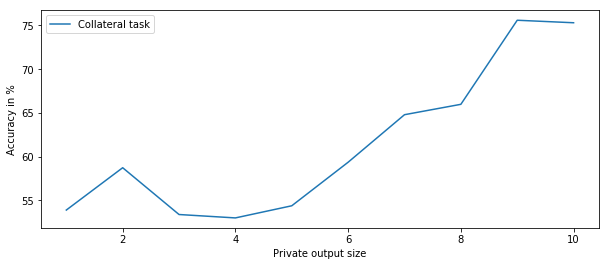

{'Collateral with output size 1': [[47.48,
   49.88,
   46.28,
   49.51,
   48.36,
   49.51,
   50.67,
   49.51,
   49.47,
   50.51,
   49.35,
   51.4,
   54.07,
   52.48,
   50.3,
   50.61,
   52.53,
   53.95,
   51.58,
   53.89,
   49.58,
   49.81,
   51.48,
   51.91,
   53.88,
   53.73,
   50.11,
   49.4,
   52.58,
   51.61,
   52.57,
   52.21,
   53.65,
   50.32,
   52.34,
   51.46,
   54.07,
   53.47,
   53.96,
   51.22,
   53.7,
   52.85,
   52.85,
   51.44,
   49.89,
   53.43,
   51.78,
   53.58,
   53.38,
   52.71],
  [50.61,
   50.61,
   50.63,
   49.51,
   56.58,
   49.28,
   50.96,
   56.6,
   57.12,
   53.19,
   56.87,
   56.83,
   55.45,
   54.94,
   56.78,
   52.78,
   57.04,
   56.73,
   56.6,
   56.19,
   54.73,
   54.71,
   56.58,
   56.37,
   57.09,
   56.27,
   54.16,
   51.23,
   56.86,
   55.43,
   56.51,
   55.6,
   56.87,
   53.1,
   55.84,
   54.41,
   57.12,
   56.68,
   56.86,
   53.2,
   56.9,
   56.21,
   56.24,
   53.84,
   51.2,
   56.84,
   54.15,
   56.7

In [13]:
show_collateral_acc_w_output_size([64, 32, 16, 8])

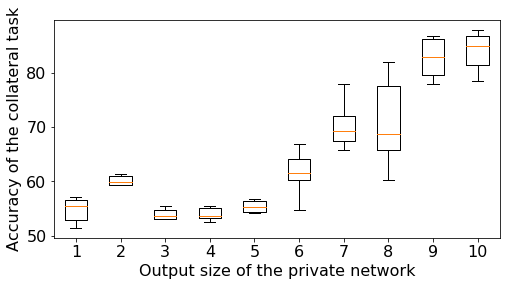

In [105]:
draw_paretto(results, "")

In [25]:
results

{'Collateral with output size 1': [[47.48,
   49.88,
   46.28,
   49.51,
   48.36,
   49.51,
   50.67,
   49.51,
   49.47,
   50.51,
   49.35,
   51.4,
   54.07,
   52.48,
   50.3,
   50.61,
   52.53,
   53.95,
   51.58,
   53.89,
   49.58,
   49.81,
   51.48,
   51.91,
   53.88,
   53.73,
   50.11,
   49.4,
   52.58,
   51.61,
   52.57,
   52.21,
   53.65,
   50.32,
   52.34,
   51.46,
   54.07,
   53.47,
   53.96,
   51.22,
   53.7,
   52.85,
   52.85,
   51.44,
   49.89,
   53.43,
   51.78,
   53.58,
   53.38,
   52.71],
  [50.61,
   50.61,
   50.63,
   49.51,
   56.58,
   49.28,
   50.96,
   56.6,
   57.12,
   53.19,
   56.87,
   56.83,
   55.45,
   54.94,
   56.78,
   52.78,
   57.04,
   56.73,
   56.6,
   56.19,
   54.73,
   54.71,
   56.58,
   56.37,
   57.09,
   56.27,
   54.16,
   51.23,
   56.86,
   55.43,
   56.51,
   55.6,
   56.87,
   53.1,
   55.84,
   54.41,
   57.12,
   56.68,
   56.86,
   53.2,
   56.9,
   56.21,
   56.24,
   53.84,
   51.2,
   56.84,
   54.15,
   56.7

In [27]:
import pickle

In [30]:
with open('results/results_par2.pickle', 'rb') as f:
    main_results = pickle.load(f)

In [36]:
main_results[0]

{'Main task 0.5_0.002_1.7_10_0': [91.31,
  96.42,
  97.58,
  98.1,
  98.34,
  98.72,
  98.82,
  98.9,
  98.93,
  99.01,
  97.92,
  97.92,
  96.91,
  98.08,
  98.2,
  98.61,
  98.72,
  97.82,
  98.44,
  98.36,
  97.6,
  98.29,
  98.5,
  98.8,
  98.97,
  98.85,
  98.0,
  98.86,
  96.62,
  99.06,
  98.81,
  98.96,
  99.03,
  99.01,
  98.77,
  98.77,
  98.73,
  98.63,
  98.64,
  98.88,
  98.85,
  98.66,
  98.84,
  98.88,
  98.82,
  98.5,
  98.68,
  98.38,
  98.77,
  98.89,
  98.95,
  99.11,
  98.95,
  98.1,
  99.03,
  98.94,
  98.33,
  98.95,
  98.78,
  98.77,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'Collateral task 0.5_0.002_1.7_10_0': [77.26,
  85.6,
  90.1,
  89.94,
  91.4,
  90.6,
  93.14,
  92.32,
  93.22,
  92.71,
  53.66,
  52.11,
  52.7,
  52.77,
  53.11,
  52.67,
  52.3,
  51.22,
  52.07,
  52.0,
  54.8,
  50.55,
  51.21,
  50.75,
  49.74,
  49.39,
  50.31,
  52.07,
  50.28,
  51.53,
  48.94,
  50.63,
  50.53,
  50

In [103]:
def show_main_acc_w_output_size(main_results_list):        
    """
    """
    res_per_size = {}
    for main_results in main_results_list:
        for key, result in main_results.items():
            if 'Main' in key:
                output_size = int(key.split('_')[3])
                if output_size not in res_per_size:
                    res_per_size[output_size] = []
                res = np.mean(result[-25:-15])
                res_per_size[output_size].append(res)
        

    
    plt.figure(figsize=(8, 4))
    sizes = [str(k) for k in sorted(res_per_size.keys())]
    print(sizes)
    

    data = [res_per_size[k] for k in sorted(res_per_size.keys())]
    print(data)

    plt.boxplot(data, showfliers=False)

    plt.ylim(93,100)

    pylab.xticks(range(1, len(sizes) + 1), sizes)
    
    plt.ylabel('Accuracy of the main task')
    plt.xlabel('Output size of the private network')
    plt.title("")

    plt.savefig('MainAcc_OutputSize.png', dpi=300)
    plt.show()


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
[[55.634, 56.213, 54.84400000000001, 57.013999999999996, 57.537, 55.870000000000005, 56.787], [93.189, 94.501, 94.06800000000001, 93.255, 94.711, 93.25900000000001, 94.36200000000001], [97.481, 97.645, 97.59199999999998, 97.19800000000001, 97.58, 97.755, 97.482], [98.451, 98.453, 98.401, 98.358, 98.51500000000001, 98.372, 98.399], [98.45500000000001, 98.876, 98.756, 98.541, 98.666, 98.61399999999999, 98.677], [99.08200000000001, 98.91, 98.958, 98.89, 98.91900000000001, 98.921, 98.987], [98.91499999999999, 98.933, 99.13, 98.866, 98.94800000000001, 98.746, 98.84400000000001], [98.982, 99.046, 99.04, 98.948, 98.91999999999999, 99.11800000000001, 99.013], [98.83200000000001, 99.176, 99.146, 98.918, 99.07399999999998, 98.506, 98.635], [98.791, 99.08000000000001, 99.17699999999999, 98.27799999999999, 99.328, 99.094, 98.91499999999999]]


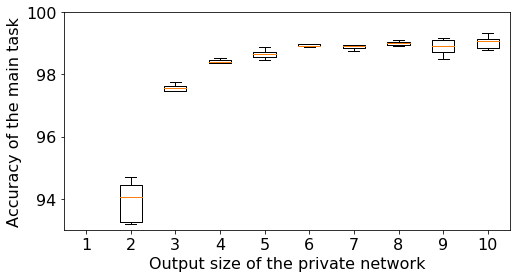

In [104]:
show_main_acc_w_output_size(main_results)

In [64]:
np.mean([98.451, 98.453, 98.401, 98.358, 98.51500000000001, 98.372, 98.399]), np.std([98.451, 98.453, 98.401, 98.358, 98.51500000000001, 98.372, 98.399])

(98.4212857142857, 0.0507281671142948)

## Conclusion

You can see that between output size 3 and 5 we get a good main accuracy while the collateral one is still very low.